In [497]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

In [498]:
class GurmukhiDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data_dir = data_dir
        self.image_set = []
        self.transform = transform
        for class_name in os.listdir(data_dir):
            class_path = os.path.join(self.data_dir, class_name)
            if os.path.isdir(class_path):
                for img_file in os.listdir(class_path):
                    self.image_set.append((os.path.join(class_path, img_file), int(class_name)))
    def __len__(self):
        return len(self.image_set)
    def __getitem__(self, index):
        image_name, label = self.image_set[index]
        image = Image.open(image_name).convert('L')
        label = int(os.path.basename(os.path.dirname(image_name)))
        if self.transform:
            image = self.transform(image)
        return image, label

In [499]:
root_dir = '/Users/sundarasubramanian/yoyo/CIS-583/HW3/Q2_GurMukhi/GurNum/'
transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = GurmukhiDataset(data_dir = f"{root_dir}train/", transform = transform)
test_dataset = GurmukhiDataset(data_dir = f"{root_dir}val/", transform = transform)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

def l1_regularization(model, lambda_l1=0.001):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return lambda_l1 * l1_norm

In [500]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 2)
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.max_pool(self.relu(self.conv1(x)))
        x = self.max_pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        return x

In [501]:
model = NN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.01)

epochs = 10
losses = []

for epoch in range(epochs):
    epoch_loss = 0
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        # loss += l1_regularization(model)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch: {epoch + 1} / {epochs}; Loss: {loss.item():.4f}")

Epoch: 1 / 10; Loss: 0.3563
Epoch: 2 / 10; Loss: 0.0696
Epoch: 3 / 10; Loss: 0.0778
Epoch: 4 / 10; Loss: 0.0086
Epoch: 5 / 10; Loss: 0.0592
Epoch: 6 / 10; Loss: 0.0497
Epoch: 7 / 10; Loss: 0.0240
Epoch: 8 / 10; Loss: 0.0129
Epoch: 9 / 10; Loss: 0.0083
Epoch: 10 / 10; Loss: 0.0065


In [502]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Accuracy of prediction: {100 * correct / total: .2f}")

Accuracy of prediction:  95.51


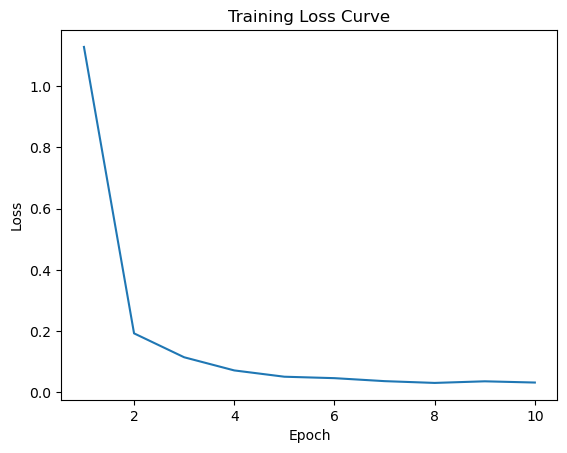

In [503]:
plt.plot(range(1, epochs+1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()